<a href="https://colab.research.google.com/github/weeg16/STINTSY/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STINTSY Machine Project**

<font face="Comic Sans MS" size=7 color='#d39aed'>??????????????????<font>

## *Group # - S16*
- **Ang, Danielle Faith**
- **De Los Santos, Hanna Angela**
- **Robles, Luis Miguel**
- **Sarreal, Sophia Althea**

# **Import Libraries**

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, learning_curve, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import skew
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression # may remove
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE # may use insead of selectKbest
from sklearn.decomposition import PCA

# for neural networks

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# **Dataset Description**

The file contains data about expenditures and other disbursements, housing characteristics, social protection, Income and other receipts and Entrepreneural Activities.

# **Structure of the Dataset**

# **Reading the Dataset**

In [87]:
fies_df = pd.read_csv('FIES PUF 2012 Vol.1.CSV')

# **Cleaning the Dataset**

In [88]:
display(fies_df.head())

,W_REGN,W_OID,W_SHSN,W_HCN,URB,RSTR,PSU,BWEIGHT,RFACT,FSIZE,...,PC_QTY,OVEN_QTY,MOTOR_BANCA_QTY,MOTORCYCLE_QTY,POP_ADJ,PCINC,NATPC,NATDC,REGDC,REGPC
0,14,101001000,2,25,2,21100,415052,138.25,200.6576,3.0,...,01,01,,,0.946172,108417.00,9,8,8,9
1,14,101001000,3,43,2,21100,415052,138.25,200.6576,12.5,...,,01,,01,0.946172,30631.60,5,9,9,4
2,14,101001000,4,62,2,21100,415052,138.25,200.6576,2.0,...,,01,,,0.946172,86992.50,9,6,6,8
3,14,101001000,5,79,2,21100,415052,138.25,200.6576,4.0,...,,01,,,0.946172,43325.75,6,6,6,6
4,14,101001000,10,165,2,21100,415052,138.25,200.6576,5.0,...,,,,01,0.946172,37481.80,6,6,6,5


In [89]:
fies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40171 entries, 0 to 40170
Columns: 119 entries, W_REGN to REGPC
dtypes: float64(5), int64(92), object(22)
memory usage: 36.5+ MB


### ***Drop ID Columns***

In [90]:
id_cols = ["W_OID", "W_SHSN", "W_HCN", "W_REGN"]
fies_df.drop(columns=id_cols, inplace=True, errors='ignore')

### ***Categorical Variables***

In [91]:
object_columns = fies_df.select_dtypes(include=['object']).columns
print("Categorical Variables (Object Dtypes):")
print(object_columns)

Categorical Variables (Object Dtypes):
Index(['OCCUP', 'KB', 'CW', 'AGELESS5', 'AGE5_17', 'EMPLOYED_PAY',
       'EMPLOYED_PROF', 'DISTANCE', 'RADIO_QTY', 'TV_QTY', 'CD_QTY',
       'STEREO_QTY', 'REF_QTY', 'WASH_QTY', 'AIRCON_QTY', 'CAR_QTY',
       'LANDLINE_QTY', 'CELLPHONE_QTY', 'PC_QTY', 'OVEN_QTY',
       'MOTOR_BANCA_QTY', 'MOTORCYCLE_QTY'],
      dtype='object')


By studying the dataset, we see that `AGELESS5`, `AGE5_17`, `EMPLOYED_PAY`,
       `EMPLOYED_PROF`, `DISTANCE`, `RADIO_QTY`, `TV_QTY`, `CD_QTY`,
       `STEREO_QTY`, `REF_QTY`, `WASH_QTY`, `AIRCON_QTY`, `CAR_QTY`,
       `LANDLINE_QTY`, `CELLPHONE_QTY`, `PC_QTY`, `OVEN_QTY`,
       `MOTOR_BANCA_QTY`, `MOTORCYCLE_QTY` all represent numeric quantities.

In [92]:
cols = ['AGELESS5', 'AGE5_17', 'EMPLOYED_PAY',
       'EMPLOYED_PROF', 'DISTANCE', 'RADIO_QTY', 'TV_QTY', 'CD_QTY',
       'STEREO_QTY', 'REF_QTY', 'WASH_QTY', 'AIRCON_QTY', 'CAR_QTY',
       'LANDLINE_QTY', 'CELLPHONE_QTY', 'PC_QTY', 'OVEN_QTY',
       'MOTOR_BANCA_QTY', 'MOTORCYCLE_QTY']

fies_df[cols] = fies_df[cols].apply(pd.to_numeric, errors='coerce')


### ***Mapping/One-Hot Encoding for Categorical Variables***

### **`HGC`** - ***(Household Head) Highest Grade Completed***

The **HGC** variable represents the highest level of education completed by the household head.

### **Education Levels and Codes:**

- **No Grade Completed:** `0`  
- **Preschool:** `10`  
- **Elementary Undergraduate:** `210-260`  
- **Elementary Graduate:** `280`  
- **High School Undergraduate:** `310-330`  
- **High School Graduate:** `350`  
- **Post-Secondary Undergraduate:** `410-420`  
- **Post-Secondary Graduate (Technical/Vocational):** `501-589`  
- **College Undergraduate:** `810-840`  
- **College Graduate:** `601-689`  
- **Post-Baccalaureate:** `900`  

In [93]:
fies_df["HGC"].unique()

array([280, 250, 552, 830, 350, 634, 554, 320, 514, 240, 581, 810, 614,
       900, 652, 330,   0, 840, 230, 584, 534, 562, 220, 310, 210, 622,
       410, 686, 572, 662, 672, 820, 260, 681, 420, 631, 684, 642, 648,
       601, 646, 676, 586, 589, 658, 689, 501, 621, 548, 632, 654, 638,
       664,  10, 522, 685, 521, 644, 542, 531, 558, 532])

As seen by using **`.unique()`**, these codes are not continuous single values, but instead appear in ranges for certain education levels.

With this, we mapped these numerical codes into standardized categories based on the dictionary.

<small>***Note that the dictionary lists College Undergraduate as ranging from **810-840** and College Graduate as **601-689**, so their values in the mapping may seem reversed.* </small>

In [94]:
print(fies_df["HGC"].between(601, 689).sum())  # Expected graduates
print(fies_df["HGC"].between(810, 840).sum())  # Expected undergraduates


4210
3237


An ordinal mapping was used to represent educational attainment levels. This ensures that there is a meaningful order.

In [95]:
conditions = [
    (fies_df["HGC"] == 0),
    (fies_df["HGC"] == 10),
    (fies_df["HGC"].between(210, 260)),
    (fies_df["HGC"] == 280),
    (fies_df["HGC"].between(310, 330)),
    (fies_df["HGC"] == 350),
    (fies_df["HGC"].between(410, 420)),
    (fies_df["HGC"].between(501, 589)),
    (fies_df["HGC"].between(810, 840)),
    (fies_df["HGC"].between(601, 689)),
    (fies_df["HGC"] >= 900)
]

values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fies_df["HGC"] = np.select(conditions, values, default=np.nan)

fies_df["HGC"]

,HGC
0,3.0
1,2.0
2,7.0
3,8.0
4,5.0
...,...
40166,5.0
40167,5.0
40168,2.0
40169,3.0


### **`OCCUP`** - ***Primary occupation of the head of the family during the past six months***

The **OCCUP** variable categorizes the primary occupation of the household head based on standardized occupation codes. These codes are grouped into broader occupational categories.

### **Occupation Groups and Codes:**
- **Officials, Executives, and Managers:** `1110-1490`  
- **Professionals:** `2111-2460`  
- **Technicians and Associate Professionals:** `3111-3480`  
- **Clerks:** `4111-4223`  
- **Service Workers and Sales Workers:** `5111-5230`  
- **Farmers, Forestry Workers, and Fishermen:** `6111-6590`  
- **Trades and Related Workers:** `7111-7442`  
- **Plant and Machine Operators and Assemblers:** `8111-8340`  
- **Laborers and Unskilled Workers:** `9111-9333`  
- **Special Occupations:** `111-113, 121-129, 930`  

In [96]:
fies_df['OCCUP'].unique()

array(['    ', '1314', '6111', '5220', '6212', '6114', '5132', '7122',
       '9211', '1316', '4121', '1130', '8322', '2331', '3118', '9132',
       '7241', '1312', '7231', '1317', '7123', '4115', '4142', '1120',
       '8324', '8263', '8321', '9131', '9112', '3152', '9133', '6420',
       '1430', '2341', '4215', '6119', '7433', '9313', '1412', '5162',
       '2449', '3450', '6219', '8141', '6112', '6122', '9151', '5169',
       '6116', '6124', '6121', '7243', '7422', '5123', '2310', '1490',
       '3434', '4190', '2412', '6310', '7414', '8275', '3415', '3151',
       '9333', '7212', '9322', '9311', '4113', '2152', '3431', '1319',
       '7141', '1224', '1231', '3131', '4211', '7242', '9120', '6330',
       '5151', '1313', '6340', '7111', '9212', '8222', '5139', '9213',
       '2154', '8231', '9312', '4131', '2224', '9152', '8113', '0129',
       '6129', '5131', '6115', '7415', '0121', '8323', '3232', '5161',
       '3416', '7432', '9161', '3132', '1315', '2221', '9111', '4133',
      

In [97]:
fies_df['OCCUP'] = fies_df['OCCUP'].apply(pd.to_numeric, errors='coerce')

Like the previous variable, we will map the ranges to represent the categories covered by `OCCUP`. We will do this before applying one-hot encoding because applying one-hot encoding directly to the raw occupation codes would treat each unique value as a separate category, resulting in an unnecessarily large number of features. This would also fail to capture the intended grouping of occupations as defined in the dataset.

In [98]:
conditions = [
    fies_df["OCCUP"].between(1110, 1490),
    fies_df["OCCUP"].between(2111, 2460),
    fies_df["OCCUP"].between(3111, 3480),
    fies_df["OCCUP"].between(4111, 4223),
    fies_df["OCCUP"].between(5111, 5230),
    fies_df["OCCUP"].between(6111, 6590),
    fies_df["OCCUP"].between(7111, 7442),
    fies_df["OCCUP"].between(8111, 8340),
    fies_df["OCCUP"].between(9111, 9333),
    fies_df["OCCUP"].isin([111, 112, 113, 121, 122, 123, 124, 125, 126, 127, 128, 129, 930])
]

values = [
    "Officials & Executives",
    "Professionals",
    "Technicians",
    "Clerks",
    "Service Workers",
    "Farmers & Fishers",
    "Trades Workers",
    "Machine Operators",
    "Laborers",
    "Special Occupations"
]

fies_df["OCCUP_GROUP"] = np.select(conditions, values, default="Unknown")

fies_df["OCCUP_GROUP"].unique()

array(['Unknown', 'Officials & Executives', 'Farmers & Fishers',
       'Service Workers', 'Trades Workers', 'Laborers', 'Clerks',
       'Machine Operators', 'Professionals', 'Technicians',
       'Special Occupations'], dtype=object)

After, one-hot encoding is applied.

In [99]:
fies_df = pd.get_dummies(fies_df, columns=["OCCUP_GROUP"], drop_first=True, dtype=int)


In [100]:
fies_df.drop(columns=["OCCUP"], inplace=True, errors='ignore')

### **`KB`** - ***Household Head Kind of Business/Industry***

The **KB** variable categorizes the primary business or industry in which the household head is engaged. These industries are grouped based on standardized industry codes.

### **Business/Industry Categories and Codes:**
- **Agriculture, Forestry, and Fishing:** `111-329`  
- **Mining and Quarrying:** `510-990`  
- **Manufacturing:** `1011-3320`  
- **Electricity, Gas, Steam, and Airconditioning Supply:** `3510-3530`  
- **Water Supply, Sewerage, Waste Management, and Remediation Activities:** `3600-3900`  
- **Construction:** `4100-4390`  
- **Wholesale and Retail Trade; Repair of Motor Vehicles and Motorcycles:** `4510-4799`  
- **Transportation and Storage:** `4911-5320`  
- **Accommodation and Food Service Activities:** `5510-5630`  
- **Information and Communication:** `5811-6399`  
- **Financial and Insurance Activities:** `6411-6630`  
- **Real Estate Activities:** `6811-6820`  
- **Professional, Scientific, and Technical Activities:** `6910-7500`  
- **Administrative and Support Service Activities:** `7710-8299`  
- **Public Administration and Defense; Compulsory Social Security:** `8411-8430`  
- **Education:** `8511-8560`  
- **Human Health and Social Work Services:** `8611-8890`  
- **Arts, Entertainment, and Recreation:** `9000-9329`  
- **Other Service Activities:** `9411-9690`  
- **Activities of Households as Employers of Domestic Personnel:** `9700`  
- **Activities of Extra-Territorial Organizations and Bodies:** `9901-9909`  

In [101]:
fies_df['KB'] = fies_df['KB'].apply(pd.to_numeric, errors='coerce')

Using the same rationale as the previous variable, mapping the ranges first before one-hot encoding ensures that the business categories are grouped appropriately.

In [102]:
conditions = [
    fies_df["KB"].between(111, 329),
    fies_df["KB"].between(510, 990),
    fies_df["KB"].between(1011, 3320),
    fies_df["KB"].between(3510, 3530),
    fies_df["KB"].between(3600, 3900),
    fies_df["KB"].between(4100, 4390),
    fies_df["KB"].between(4510, 4799),
    fies_df["KB"].between(4911, 5320),
    fies_df["KB"].between(5510, 5630),
    fies_df["KB"].between(5811, 6399),
    fies_df["KB"].between(6411, 6630),
    fies_df["KB"].between(6811, 6820),
    fies_df["KB"].between(6910, 7500),
    fies_df["KB"].between(7710, 8299),
    fies_df["KB"].between(8411, 8430),
    fies_df["KB"].between(8511, 8560),
    fies_df["KB"].between(8611, 8890),
    fies_df["KB"].between(9000, 9329),
    fies_df["KB"].between(9411, 9690),
    fies_df["KB"] == 9700,
    fies_df["KB"].between(9901, 9909)
]

values = [
    "Agriculture", "Mining", "Manufacturing", "Electricity", "Water Supply", "Construction",
    "Retail", "Transport", "Food Service", "IT", "Finance", "Real Estate", "Professional",
    "Admin", "Public Admin", "Education", "Health", "Arts", "Other Services",
    "Household Employers", "Extra-territorial"
]

fies_df["KB_Group"] = np.select(conditions, values, default="Unknown")

After nominal mapping, we can apply one-hot encoding.

In [103]:
fies_df = pd.get_dummies(fies_df, columns=["KB_Group"], drop_first=True, dtype=int)

In [104]:
fies_df.drop(columns=["KB"], inplace=True, errors='ignore')

### **`CW`** - ***Household Head Class of Worker***

The **CW** variable identifies the **class of worker** for the household head during the second visit. It categorizes the employment type based on the nature of the employer or work arrangement.  

### **Categories and Codes:**  
- **Worked for private household**: `0`  
- **Worked for private establishment**: `1`  
- **Worked for government/government corporation**: `2`  
- **Self-employed without any employee**: `3`  
- **Employer in own family-operated farm or business**: `4`  
- **Worked with pay in own family-operated farm or business**: `5`  
- **Worked without pay in own family-operated farm or business**: `6`  

In [105]:
fies_df['CW'] = fies_df['CW'].apply(pd.to_numeric, errors='coerce')

This is mapped into categorical labels to make the data more interpretable before applying one-hot encoding.

In [106]:
cw_mapping = {
    0: "Private Household",
    1: "Private Establishment",
    2: "Government",
    3: "Self-Employed",
    4: "Employer in Family Business",
    5: "Worked with Pay in Family Business",
    6: "Worked without Pay in Family Business"
}

fies_df["CW_Group"] = fies_df["CW"].map(cw_mapping)


Apply one-hot encoding.

In [107]:
fies_df = pd.get_dummies(fies_df, columns=["CW_Group"], drop_first=True, dtype=int)

In [108]:
fies_df.drop(columns=["CW"], inplace=True, errors='ignore')

Check if there are any more `object` dtypes.

In [109]:
fies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40171 entries, 0 to 40170
Columns: 149 entries, URB to CW_Group_Worked without Pay in Family Business
dtypes: float64(25), int64(124)
memory usage: 45.7 MB


### **`WALLS`** - ***Type of Walls***

The **WALLS** variable identifies the **type of wall** during the second visit.

### **Categories and Codes:**  
- **Strong materials**: `1`  
- **Light materials**: `2`  
- **Salvage/makeshift**: `3`  
- **Mixed but predominantly strong**: `4`  
- **Mixed but predominantly light**: `5`  
- **Mixed but predominantly salvaged**: `6`  
- **Not Applicable**: `7`  

In [110]:
fies_df['WALLS'] = fies_df['WALLS'].apply(pd.to_numeric, errors='coerce')

In [111]:
fies_df["WALLS"].value_counts()

,count
WALLS,
1,26582
2,8198
4,3432
5,1518
3,334
6,102
7,5


In [112]:
fies_df = fies_df[fies_df["WALLS"] != 7]

In [113]:
walls_mapping = {
    1: "Strong materials",
    2: "Light materials",
    3: "Salvage/makeshift",
    4: "Mixed but predominantly strong",
    5: "Mixed but predominantly light",
    6: "Mixed but predominantly salvaged"
}

fies_df["WALLS_Group"] = fies_df["WALLS"].map(walls_mapping)


<ipython-input-113-5ccc8c0b8c17>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fies_df["WALLS_Group"] = fies_df["WALLS"].map(walls_mapping)


In [114]:
fies_df = pd.get_dummies(fies_df, columns=["WALLS_Group"], drop_first=True, dtype=int)

In [115]:
fies_df.drop(columns=["WALLS"], inplace=True, errors='ignore')

### **`WATER`** - ***Water Source***

The **WATER** variable identifies the **water source** during the second visit.

### **Categories and Codes:**  
- **Own use, faucet, community water system**: `1`  
- **Shared, faucet, community water system**: `2`  
- **Own use, tubed/piped deep well**: `3`  
- **Shared, tubed/piped deep well**: `4`  
- **Tubed/piped shallow well**: `5`  
- **Dug well**: `6`  
- **Protected spring**: `7`  
- **Unprotected spring**: `8`
- **Lake, river, rain, and others**: `9`
- **Peddler**: `10 `
- **Bottled water**: `11`
- **Others**: `12`

In [116]:
fies_df['WATER'] = fies_df['WATER'].apply(pd.to_numeric, errors='coerce')

In [117]:
water_mapping = {
    1: "Own use, faucet, community water system",
    2: "Shared, faucet, community water system",
    3: "Own use, tubed/piped deep well",
    4: "Shared, tubed/piped deep well",
    5: "Tubed/piped shallow well",
    6: "Dug well",
    7: "Protected spring",
    8: "Unprotected spring",
    9: "Lake, river, rain, and others",
    10: "Peddler",
    11: "Bottled water",
    12: "Others"
}

fies_df["WATER_Group"] = fies_df["WATER"].map(walls_mapping)


In [118]:
fies_df = pd.get_dummies(fies_df, columns=["WATER_Group"], drop_first=True, dtype=int)

In [119]:
fies_df.drop(columns=["WATER"], inplace=True, errors='ignore')

### **`MS`** - ***Marital Status***

In [120]:
fies_df['MS'] = fies_df['MS'].apply(pd.to_numeric, errors='coerce')

In [121]:
marital_mapping = {
    1: "Single",
    2: "Married",
    3: "Widowed",
    4: "Divorced",
    5: "Separated",
}

In [122]:
fies_df['MS_Group'] = fies_df['MS'].map(marital_mapping)

In [123]:
fies_df = pd.get_dummies(fies_df, columns=['MS_Group'], drop_first=True, dtype=int)

In [124]:
fies_df.drop(columns=["MS"], inplace=True, errors='ignore')

### **`SPOUSE_EMP`** - ***Spouse Employment***

In [125]:
fies_df['SPOUSE_EMP'] = fies_df['SPOUSE_EMP'].apply(pd.to_numeric, errors='coerce')

In [126]:
spouse_mapping = {
    1: "Yes",
    2: "No",
    3: "Not Applicable"
}

In [127]:
fies_df['SPOUSE_EMP_Group'] = fies_df['SPOUSE_EMP'].map(spouse_mapping)

In [128]:
fies_df = pd.get_dummies(fies_df, columns=['SPOUSE_EMP_Group'], drop_first=True, dtype=int)

In [129]:
fies_df.drop(columns=["SPOUSE_EMP"], inplace=True, errors='ignore')

### **`BLDG_TYPE`** - ***Building Type***

In [130]:
fies_df['BLDG_TYPE'] = fies_df['BLDG_TYPE'].apply(pd.to_numeric, errors='coerce')

In [131]:
building_mapping = {
    1: "Single",
    2: "Duplex",
    3: "Multi-unit residential",
    4: "Commercial/Industrial/agricultural",
    5: "Institutional living quarters",
    6: "Other housing unit (boat, cve, others)"
}

In [132]:
fies_df['BLDG_TYPE_Group'] = fies_df['BLDG_TYPE'].map(building_mapping)

In [133]:
fies_df = pd.get_dummies(fies_df, columns=['BLDG_TYPE_Group'], drop_first=True, dtype=int)

In [134]:
fies_df.drop(columns=["BLDG_TYPE"], inplace=True, errors='ignore')

### **``**

### ***Handling Missing Data***

Now, since we converted the dtypes of categorical variables into float/int, we check for missing values.

In [135]:
missing_values = fies_df.isnull().sum()
print("Missing values per col: ", missing_values[missing_values>0])

Missing values per col:  AGELESS5           15359
AGE5_17             8236
EMPLOYED_PAY        8295
EMPLOYED_PROF      12696
DISTANCE           16804
RADIO_QTY          16051
TV_QTY              7810
CD_QTY             14263
STEREO_QTY         23010
REF_QTY            17777
WASH_QTY           20103
AIRCON_QTY         25627
CAR_QTY            26154
LANDLINE_QTY       26130
CELLPHONE_QTY       6424
PC_QTY             23426
OVEN_QTY           24131
MOTOR_BANCA_QTY    27532
MOTORCYCLE_QTY     23125
dtype: int64


We check the percentage of missing data per column.

In [136]:
missing_percent = (fies_df.isnull().sum() / len(fies_df)) * 100
missing_percent = missing_percent[missing_percent > 0]
print(missing_percent)


AGELESS5           38.238809
AGE5_17            20.504905
EMPLOYED_PAY       20.651795
EMPLOYED_PROF      31.608823
DISTANCE           41.836379
RADIO_QTY          39.961659
TV_QTY             19.444306
CD_QTY             35.510133
STEREO_QTY         57.287258
REF_QTY            44.258826
WASH_QTY           50.049793
AIRCON_QTY         63.802719
CAR_QTY            65.114774
LANDLINE_QTY       65.055022
CELLPHONE_QTY      15.993626
PC_QTY             58.322960
OVEN_QTY           60.078176
MOTOR_BANCA_QTY    68.545536
MOTORCYCLE_QTY     57.573570
dtype: float64


For those with missing values `> 50%` , we drop the column.

In [137]:
missing_threshold = 0.50
missing_percent = fies_df.isnull().mean()

cols_to_drop = missing_percent[missing_percent > missing_threshold].index
fies_df = fies_df.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop.tolist())

Dropped columns: ['STEREO_QTY', 'WASH_QTY', 'AIRCON_QTY', 'CAR_QTY', 'LANDLINE_QTY', 'PC_QTY', 'OVEN_QTY', 'MOTOR_BANCA_QTY', 'MOTORCYCLE_QTY']


In [138]:
num_imputer = SimpleImputer(strategy="median")
numeric_cols = fies_df.select_dtypes(include=['number']).columns
fies_df[numeric_cols] = num_imputer.fit_transform(fies_df[numeric_cols])

# **Exploratory Data Analysis**

### ***Handle Outliers***

In [139]:
Q1_target = fies_df["TOINC"].quantile(0.25)
Q3_target = fies_df["TOINC"].quantile(0.75)
IQR_target = Q3_target - Q1_target
lower_bound_target = Q1_target - 1.5 * IQR_target
upper_bound_target = Q3_target + 1.5 * IQR_target

fies_df = fies_df[(fies_df["TOINC"] >= lower_bound_target) & (fies_df["TOINC"] <= upper_bound_target)]

In [140]:
numeric_cols = fies_df.select_dtypes(include=['int64', 'float64']).columns

### ***What are the skew values of each variable?***

Since there are 100+ variables, visually representing and analyzing the distribution would be difficult. Instead, we will use the `.skew()` function. We will consider a value to be **highly skewed** if the skew value is `> 1`.

In [141]:
skewness_values = fies_df[numeric_cols].skew()
print(skewness_values)

URB                                              -0.581926
RSTR                                             -2.334945
PSU                                               0.025939
BWEIGHT                                           2.138654
RFACT                                             1.806781
                                                   ...    
SPOUSE_EMP_Group_Yes                              0.378435
BLDG_TYPE_Group_Duplex                            6.338559
BLDG_TYPE_Group_Institutional living quarters    60.824338
BLDG_TYPE_Group_Multi-unit residential            5.688501
BLDG_TYPE_Group_Single                           -4.006590
Length: 155, dtype: float64


For values that are categorical and were mapped/one-hot encoded, we will exclude them from **Log Transformation**. We will also exclude variables that are discrete, for example, quantity variables such as number of children aged less than 5 in a household.

In [142]:
exclude_cols = [
    "SEX", "JOB", "WATER", "ELECTRIC",
    "HGC", "NATPC", "NATDC", "REGDC", "REGPC"
    "OCCUP_GROUP", "KB_Group", "CW_Group",
]

exclude_one_hot = [col for col in fies_df.columns if "OCCUP_GROUP_" in col or "KB_Group_" in col or "CW_Group_" in col
                   or "BLDG_TYPE_Group_" in col or "MS_Group_" in col or "SPOUSE_EMP_Group_" in col or "Region_" in col
                   or "WALLS_Group_" in col or "WATER_Group_" in col or "ELECTRIC_Group_"]

exclude_cols += exclude_one_hot

exclude_qty = [col for col in fies_df.columns if "QTY" in col or "AGELESS5" in col or "AGE5_17" in col]

exclude_cols += exclude_qty

print("Columns to Exclude from transformation:", exclude_cols)


Columns to Exclude from transformation: ['SEX', 'JOB', 'WATER', 'ELECTRIC', 'HGC', 'NATPC', 'NATDC', 'REGDC', 'REGPCOCCUP_GROUP', 'KB_Group', 'CW_Group', 'URB', 'RSTR', 'PSU', 'BWEIGHT', 'RFACT', 'FSIZE', 'AGRI_SAL', 'NONAGRI_SAL', 'WAGES', 'NETSHARE', 'CASH_ABROAD', 'CASH_DOMESTIC', 'RENTALS_REC', 'INTEREST', 'PENSION', 'DIVIDENDS', 'OTHER_SOURCE', 'NET_RECEIPT', 'REGFT', 'NET_CFG', 'NET_LPR', 'NET_FISH', 'NET_FOR', 'NET_RET', 'NET_MFG', 'NET_COM', 'NET_TRANS', 'NET_MIN', 'NET_CONS', 'NET_NEC', 'EAINC', 'TOINC', 'LOSSES', 'T_BREAD', 'T_MEAT', 'T_FISH', 'T_MILK', 'T_OIL', 'T_FRUIT', 'T_VEG', 'T_SUGAR', 'T_FOOD_NEC', 'T_COFFEE', 'T_MINERAL', 'T_ALCOHOL', 'T_TOBACCO', 'T_OTHER_VEG', 'T_FOOD_HOME', 'T_FOOD_OUTSIDE', 'T_FOOD', 'T_CLOTH', 'T_FURNISHING', 'T_HEALTH', 'T_HOUSING_WATER', 'T_ACTRENT', 'T_RENTVAL', 'T_IMPUTED_RENT', 'T_BIMPUTED_RENT', 'T_TRANSPORT', 'T_COMMUNICATION', 'T_RECREATION', 'T_EDUCATION', 'T_MISCELLANEOUS', 'T_OTHER_EXPENDITURE', 'T_OTHER_DISBURSEMENT', 'T_NFOOD', 'T_T

In [143]:
skewed_cols = skewness_values[skewness_values > 1].index
print("Highly skewed variables:", skewed_cols)

Highly skewed variables: Index(['BWEIGHT', 'RFACT', 'AGRI_SAL', 'NONAGRI_SAL', 'WAGES', 'NETSHARE',
       'CASH_ABROAD', 'CASH_DOMESTIC', 'RENTALS_REC', 'INTEREST',
       ...
       'WATER_Group_Mixed but predominantly salvaged',
       'WATER_Group_Mixed but predominantly strong',
       'WATER_Group_Salvage/makeshift', 'MS_Group_Separated',
       'MS_Group_Single', 'MS_Group_Widowed',
       'SPOUSE_EMP_Group_Not Applicable', 'BLDG_TYPE_Group_Duplex',
       'BLDG_TYPE_Group_Institutional living quarters',
       'BLDG_TYPE_Group_Multi-unit residential'],
      dtype='object', length=128)


In [144]:
negatively_skewed_cols = skewness_values[skewness_values < -1].index
print("Negatively skewed variables: ", negatively_skewed_cols)

Negatively skewed variables:  Index(['RSTR', 'HSE_ALTERTN', 'RADIO_QTY', 'MS_Group_Married',
       'BLDG_TYPE_Group_Single'],
      dtype='object')


For skewed variables `> 1`, we will use **Log Transformation**.

In [145]:
skewed_cols = [col for col in skewed_cols if col not in exclude_cols]

for col in skewed_cols:
    min_val = fies_df[col].min()
    if min_val < 0:
        fies_df[col] = np.log1p(fies_df[col] - min_val + 1)
    else:
        fies_df[col] = np.log1p(fies_df[col])

numeric_cols = [col for col in fies_df.select_dtypes(include=["int64", "float64"]).columns if col not in exclude_cols and col not in skewed_cols]

for col in numeric_cols:
    min_val = fies_df[col].min()
    if min_val < 0:
        fies_df[col] = np.log1p(fies_df[col] - min_val + 1)
    else:
        fies_df[col] = np.log1p(fies_df[col])


For skewed variables `< -1`, we will use **Square Transformation**.

In [146]:
fies_df[negatively_skewed_cols] = fies_df[negatively_skewed_cols] ** 2

In [147]:
#fies_df.hist(figsize=(30, 10), bins=30)
#plt.suptitle("Feature Distributions", fontsize=20)
#plt.show()

# **Splitting the Dataset (Setting up KFold) and Feature Selection**

In [148]:
X = fies_df.drop(columns=["TOINC"])
y = fies_df["TOINC"]

In [149]:
y_mean = np.mean(y)

In [150]:
threshold = 0.85
corr_matrix = X.corr().abs()
features_to_drop = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            avg_corr1 = corr_matrix[feature1].mean()
            avg_corr2 = corr_matrix[feature2].mean()
            feature_to_remove = feature1 if avg_corr1 > avg_corr2 else feature2
            features_to_drop.add(feature_to_remove)

X_filtered = X.drop(columns=features_to_drop)
print("Dropped Features (High Correlation):", features_to_drop)

Dropped Features (High Correlation): {'T_TOREC', 'CW_Group_Government', 'NONAGRI_SAL', 'JOB', 'NATDC', 'FSIZE', 'NATPC', 'T_FOOD', 'T_TOTEX', 'MS_Group_Married', 'T_HOUSING_WATER', 'T_RENTVAL', 'KB_Group_Unknown', 'BWEIGHT', 'T_TOTDIS'}


In [151]:
model_for_rfe = LinearRegression()
rfe = RFE(estimator=model_for_rfe, n_features_to_select=10)
rfe.fit(X_filtered, y)

X_final = X_filtered.loc[:, rfe.support_]
selected_features = X_filtered.loc[:, rfe.support_].columns.tolist()
print("Final Selected Features:", selected_features)

Final Selected Features: ['WAGES', 'NETSHARE', 'CASH_ABROAD', 'RENTALS_REC', 'INTEREST', 'PENSION', 'OTHER_SOURCE', 'REGFT', 'EAINC', 'T_IMPUTED_RENT']


In [152]:
X_vif = pd.DataFrame(X_final, columns=X_final.columns)  # Convert to DataFrame if not already

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

          Feature       VIF
9  T_IMPUTED_RENT  2.092056
0           WAGES  1.400755
8           EAINC  1.245198
2     CASH_ABROAD  1.207967
7           REGFT  1.148439
5         PENSION  1.103841
3     RENTALS_REC  1.050302
1        NETSHARE  1.032043
4        INTEREST  1.004940
6    OTHER_SOURCE  1.001405


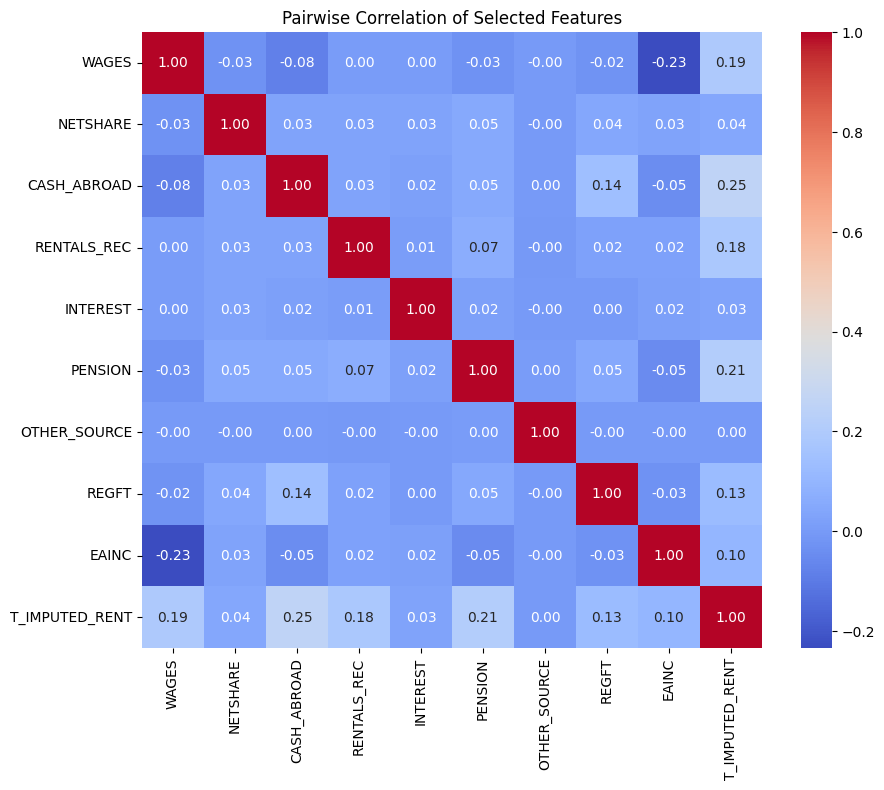

In [153]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_final.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pairwise Correlation of Selected Features")
plt.show()

In [154]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-5)

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

Lowering **patience** to ~10 may stop training earlier without hurting performance.

standardize after splitting dataset

# **Initial Model Training**

## **Linear Regression**

In [155]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [156]:
mae_scores = []

In [157]:
for train_index, val_index in kf.split(X_final):
    X_train, X_val = X_final.iloc[train_index], X_final.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_val_scaled)
    mae_scores.append(mean_absolute_error(y_val, y_pred))

print("Linear Regression Mean MAE:", np.mean(mae_scores))

Linear Regression Mean MAE: 10492.027775935898


### ***Check for Overfitting and Multicollinearity***

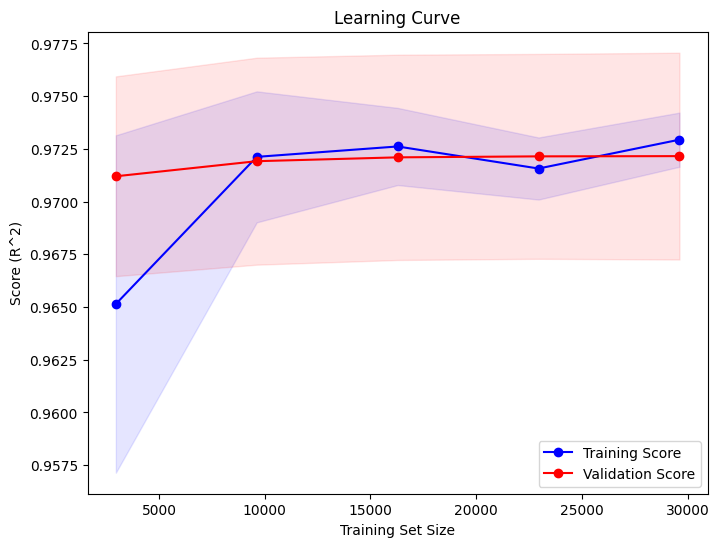

In [158]:
train_sizes, train_scores, val_scores = learning_curve(
    model, X_final, y, cv=5, scoring="r2", n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")

plt.plot(train_sizes, val_mean, 'o-', label="Validation Score", color="red")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="red")

plt.xlabel("Training Set Size")
plt.ylabel("Score (R^2)")
plt.title("Learning Curve")
plt.legend()
plt.show()

## **K Nearest Neighbors Regression**

We first initialized an instance of the imported KNeighborsRegressor class from sklearn.neighbors. The KNN regressor will be used to predict target values based on the k-nearest neighbors in the feature space.

In [160]:
#knn = KNeighborsRegressor()

Here, the KNN regressor is fitted to the training data (X_train and y_train). This step allows the model to learn the relationship between the features and the target values.

In [161]:
#knn.fit(X_train, y_train)

Next, the fitted KNN regressor is used to predict the target values for the test data (X_test). The predictions are stored in y_pred. The model's performance is then evaluated using Mean Squared Error (MSE). The mean_squared_error function compares the true target values (y_test) with the predicted values (y_pred) and calculates the MSE, which is then printed.

In [162]:
#y_pred = knn.predict(X_final)
#print(mean_squared_error(y_val, y_pred))

The same is done for the train data.

In [163]:
#y_train_pred = knn.predict(X_train)
#print(mean_squared_error(y_train, y_train_pred))

In [164]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [165]:
mae_scores = []

In [166]:
for train_index, val_index in kf.split(X_final):
    X_train, X_val = X_final.iloc[train_index], X_final.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]


    # Scale Data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)


    # Train KNN Model
    knn = KNeighborsRegressor(n_neighbors=10)  # You can tune n_neighbors
    knn.fit(X_train_scaled, y_train)


    # Predict & Compute MAE
    y_pred = knn.predict(X_val_scaled)
    mae = mean_absolute_error(y_val, y_pred)
    mae_scores.append(mae)


print("MAE Scores per Fold:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))

MAE Scores per Fold: [14978.466468602293, 14642.39384199865, 14257.477555705604, 14761.656361426256, 14348.192639113991]
Mean MAE: 14597.637373369358


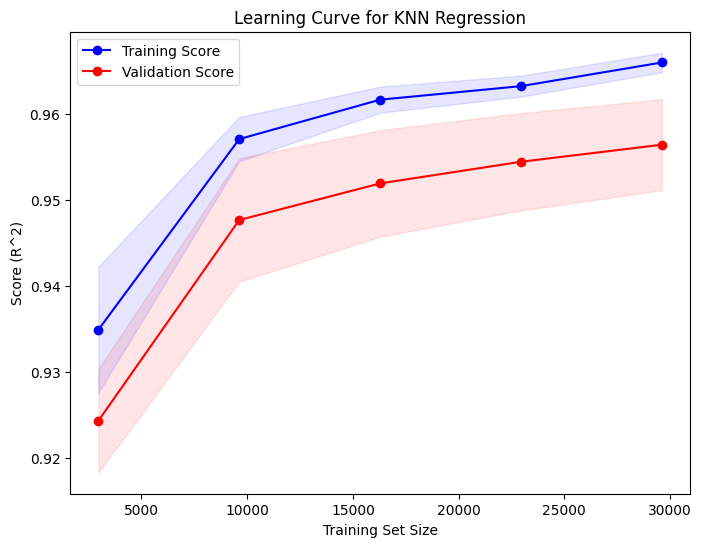

In [167]:
train_sizes, train_scores, val_scores = learning_curve(
    knn, X_final, y, cv=5, scoring="r2", n_jobs=-1
)


# Compute mean and std for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")


plt.plot(train_sizes, val_mean, 'o-', label="Validation Score", color="red")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="red")


plt.xlabel("Training Set Size")
plt.ylabel("Score (R^2)")
plt.title("Learning Curve for KNN Regression")
plt.legend()
plt.show()


## **Neural Networks**

This section trains a **Neural Network** (**NN**) **for regression** to predict **Total Income** (**TOINC**). The model is designed to handle **non-linear relationship**s in the data and is evaluated to ensure it is **neither overfitting nor underfitting**.

To improve performance, the model consists of **three hidden layers** (128, 64, and 32 neurons) with **ReLU activation**. A **Dropout layer** (**0.2**) is added to prevent overfitting.

In [169]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.2),

    Dense(64),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.2),

    Dense(16),
    BatchNormalization(),
    Activation("relu"),

    Dense(1, activation="linear")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Then we use the **Adam optimizer** with a **lower learning rate** (**0.005**) to improve stability and generalization. The **loss function** is **Mean Squared Error** (**MSE**), and **Mean Absolute Error** (**MAE**) is used to track performance.

In [170]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

The model is configured to optimize learning with reduced sensitivity to fluctuations.

The model is trained for 50 epochs, avoiding unnecessary computations while maintaining performance. (This might take a while. Batch size = 8 leads to longer training time but more stable results. For faster training, we can try batch size = 16 and compare MAE. )

In [171]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

NameError: name 'X_test_scaled' is not defined

After training, the model has learned patterns in the training data while monitoring performance on validation data.

The trained model is then tested on unseen data to measure **Mean Absolute Error** (**MAE**) and overall **loss** (**MSE**).

In [ ]:
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test MAE: {test_mae}")

A low MAE indicates that the model’s predictions are close to actual values. If MAE is too high, further tuning may be needed.

To ensure proper generalization, we **plot the loss curves** for both training and validation data.

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs. Validation Loss (MSE)")
plt.legend()
plt.show()

We then compare the model’s predictions with actual values from the test dataset.

In [ ]:
y_pred = model.predict(X_test_scaled)

results = pd.DataFrame({"Actual": y_test[:5].values, "Predicted": y_pred[:5].flatten()})
print(results)

# **Hyperparameter Tuning**